# Contextual Bayesian Optimisation via Large Language Models

This notebook will:
- Demonstrate the works of [BO-Lift](https://github.com/ur-whitelab/BO-LIFT), which focusses on few-shot/in-context learning (FS/ICL) for estimating the aqueous solubility (ESOL--Estimated SOLubility) of a compound and also yield calculations from chemical compound interactions. The advantages of ICL are demonstrated here: [ICL-Wiki](https://en.wikipedia.org/wiki/In-context_learning_(natural_language_processing)). 
- Show attempts of extending and evaluating the works of [BO-Lift](https://arxiv.org/pdf/2304.05341.pdf) via (non-exhaustive):
1. Implementation of advanced contextual prompting (not simply just compound+solubility or compound+yield) through automatic feature engineering (specifically selection).
2. Implementation of further acquisition functions for the Bayesian optimisation protocol.
- If possible, try alternative frameworks:
1. Experimenting with chain-of-thought prompting variations ([Chain-of-Thought](https://www.promptingguide.ai/techniques/cot)).
2. Experimenting with tree-of-thought prompting ([Tree-of-Thought](https://www.promptingguide.ai/techniques/tot)).
3. Multi-task Bayesian optimization (for instance, we might want to optimize not just for solubility, but also for yield, or some other property), you could use a multi-task Bayesian optimization approach.

<DIV STYLE="background-color:#000000; height:10px; width:100%;">

# Import Libraries

In [45]:
# Standard Library
import os
import matplotlib.pyplot as plt
import itertools
from typing import *

# Third Party
import pickle
import copy
import seaborn as sns
import numpy as np
import uncertainty_toolbox as uct
import pandas as pd
import openai
import xgboost as xgb
import optuna
import cloudpickle
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_regression, RFE
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import loguniform
from tqdm import tqdm
from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)


# Private
import bolift
import qafnet
from qafnet.helper import GaussDist, DiscreteDist
from qafnet.qaf import PromptTemplate

In [3]:
# Seed results
np.random.seed(0)

In [4]:
# Default OpenAI API Key

# Data Preparation

The original paper used data corresponding to this paper [ESOL](https://www.researchgate.net/publication/8551133_ESOL_Estimating_Aqueous_Solubility_Directly_from_Molecular_Structure) - this corresponds to only 927 examples with 7 columns, with only 3 being important. This is not enough information for us to compare alternative techniques, hence we will use the larger dataset, provided from Kaggle, which incorporates more information about these molecules [AqSOL](https://www.kaggle.com/datasets/sorkun/aqsoldb-a-curated-aqueous-solubility-dataset?resource=download).

In [5]:
# Establish path to partial solubility data (used in BO-Lift paper)
esol_df = pd.read_csv("paper/data/esol_iupac.csv")

In [6]:
# Establish path to full solubility data (from Aqsol databse)
aqsol_df = pd.read_csv("paper/data/full_solubility.csv")

In [7]:
# Clean
aqsol_df = aqsol_df.dropna()
aqsol_df = aqsol_df.drop_duplicates().reset_index(drop=True)
aqsol_df.rename(columns={'Name': 'Compound ID'}, inplace=True)
aqsol_df = aqsol_df.drop(["ID"], axis=1)

Given the token length of the OpenAI language models, we will work with chemical compounds which have a length of less than 15.

In [8]:
# Keep compounds that "read" easily
aqsol_df = aqsol_df[aqsol_df["Compound ID"].str.len()<15].reset_index(drop=True)
aqsol_df

,Compound ID,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,MolLogP,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,vinyltoluene,"InChI=1S/C9H10/c1-3-9-6-4-5-8(2)7-9/h3-7H,1H2,2H3",JZHGRUMIRATHIU-UHFFFAOYSA-N,Cc1cccc(C=C)c1,-3.123150,0.000000,1,G1,118.179,2.63802,...,1.0,46.0,1.0,0.0,0.0,1.0,0.00,55.836626,3.070761,211.033225
1,hydroxylamine,"InChI=1S/H3NO/c1-2/h2H,1H2",AVXURJPOCDRRFD-UHFFFAOYSA-N,NO,-0.763034,0.861298,7,G4,33.030,-0.66570,...,0.0,14.0,0.0,0.0,0.0,0.0,46.25,12.462472,1.000000,2.000000
2,molybdenum,InChI=1S/Mo,ZOKXTWBITQBERF-UHFFFAOYSA-N,[Mo],-4.203848,0.000000,1,G1,95.940,-0.00250,...,0.0,6.0,0.0,0.0,0.0,0.0,0.00,21.756566,0.000000,0.000000
3,Prednisolone,InChI=1S/C21H28O5/c1-19-7-5-13(23)9-12(19)3-4-...,OIGNJSKKLXVSLS-VWUMJDOOSA-N,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=CC(=O)C=C[C@...,-3.178447,0.015047,2,G3,360.450,1.55760,...,2.0,142.0,0.0,3.0,4.0,4.0,94.83,153.341308,1.747281,723.913082
4,fluoromethane,InChI=1S/CH3F/c1-2/h1H3,NBVXSUQYWXRMNV-UHFFFAOYSA-N,CF,-0.175874,0.000000,1,G1,34.033,0.58570,...,0.0,14.0,0.0,0.0,0.0,0.0,0.00,12.904786,1.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1888,tetracaine,InChI=1S/C15H24N2O2/c1-4-5-10-16-14-8-6-13(7-9...,GKCBAIGFKIBETG-UHFFFAOYSA-N,C(c1ccc(cc1)NCCCC)(=O)OCCN(C)C,-3.010000,0.000000,1,G1,264.369,2.61700,...,8.0,106.0,1.0,0.0,0.0,1.0,41.57,115.300645,2.394548,374.236893
1889,tetracycline,InChI=1S/C22H24N2O8/c1-21(31)8-5-4-6-11(25)12(...,OFVLGDICTFRJMM-WESIUVDSSA-N,OC1=C(C(C2=C(O)[C@@](C(C(C(N)=O)=C(O)[C@H]3N(C...,-2.930000,0.000000,1,G1,444.440,-0.21440,...,2.0,170.0,1.0,0.0,3.0,4.0,181.62,182.429237,2.047922,1148.584975
1890,thymol,InChI=1S/C10H14O/c1-7(2)9-5-4-8(3)6-10(9)11/h4...,MGSRCZKZVOBKFT-UHFFFAOYSA-N,c1(cc(ccc1C(C)C)C)O,-2.190000,0.019222,3,G5,150.221,2.82402,...,1.0,60.0,1.0,0.0,0.0,1.0,20.23,67.685405,3.092720,251.049732
1891,verapamil,"InChI=1S/C27H38N2O4/c1-20(2)27(19-28,22-10-12-...",SGTNSNPWRIOYBX-UHFFFAOYSA-N,COc1ccc(CCN(C)CCCC(C#N)(C(C)C)c2ccc(OC)c(OC)c2...,-3.980000,0.000000,1,G1,454.611,5.09308,...,13.0,180.0,2.0,0.0,0.0,2.0,63.95,198.569223,2.023333,938.203977


In [9]:
aqsol_df[["Compound ID", "Solubility"]]

,Compound ID,Solubility
0,vinyltoluene,-3.123150
1,hydroxylamine,-0.763034
2,molybdenum,-4.203848
3,Prednisolone,-3.178447
4,fluoromethane,-0.175874
...,...,...
1888,tetracaine,-3.010000
1889,tetracycline,-2.930000
1890,thymol,-2.190000
1891,verapamil,-3.980000


# Feature Selection

## Correlation

Pearson or Spearman correlation coefficients can be used to measure the linear relationship between each feature and the target variable. Features with a higher absolute correlation coefficient have more predictive power.
Note that correlation does not imply causation and this does not take into account interactive relationships.

In [10]:
# Keep columns to check correlation
cols_to_keep = []
for i in range(len(aqsol_df.columns)):
    if aqsol_df.dtypes[aqsol_df.columns[i]] == 'int64' or aqsol_df.dtypes[aqsol_df.columns[i]] == 'float64':
        cols_to_keep.append(aqsol_df.columns[i])
compound_df = aqsol_df["Compound ID"]
features_df = aqsol_df[cols_to_keep]
compound_df, features_df

(0        vinyltoluene
 1       hydroxylamine
 2          molybdenum
 3        Prednisolone
 4       fluoromethane
             ...      
 1888       tetracaine
 1889     tetracycline
 1890           thymol
 1891        verapamil
 1892         warfarin
 Name: Compound ID, Length: 1893, dtype: object,
       Solubility        SD  Ocurrences    MolWt  MolLogP     MolMR  \
 0      -3.123150  0.000000           1  118.179  2.63802   41.2700   
 1      -0.763034  0.861298           7   33.030 -0.66570    5.9739   
 2      -4.203848  0.000000           1   95.940 -0.00250    0.0000   
 3      -3.178447  0.015047           2  360.450  1.55760   95.0484   
 4      -0.175874  0.000000           1   34.033  0.58570    7.0320   
 ...          ...       ...         ...      ...      ...       ...   
 1888   -3.010000  0.000000           1  264.369  2.61700   78.6762   
 1889   -2.930000  0.000000           1  444.440 -0.21440  109.5409   
 1890   -2.190000  0.019222           3  150.221  2.82402  

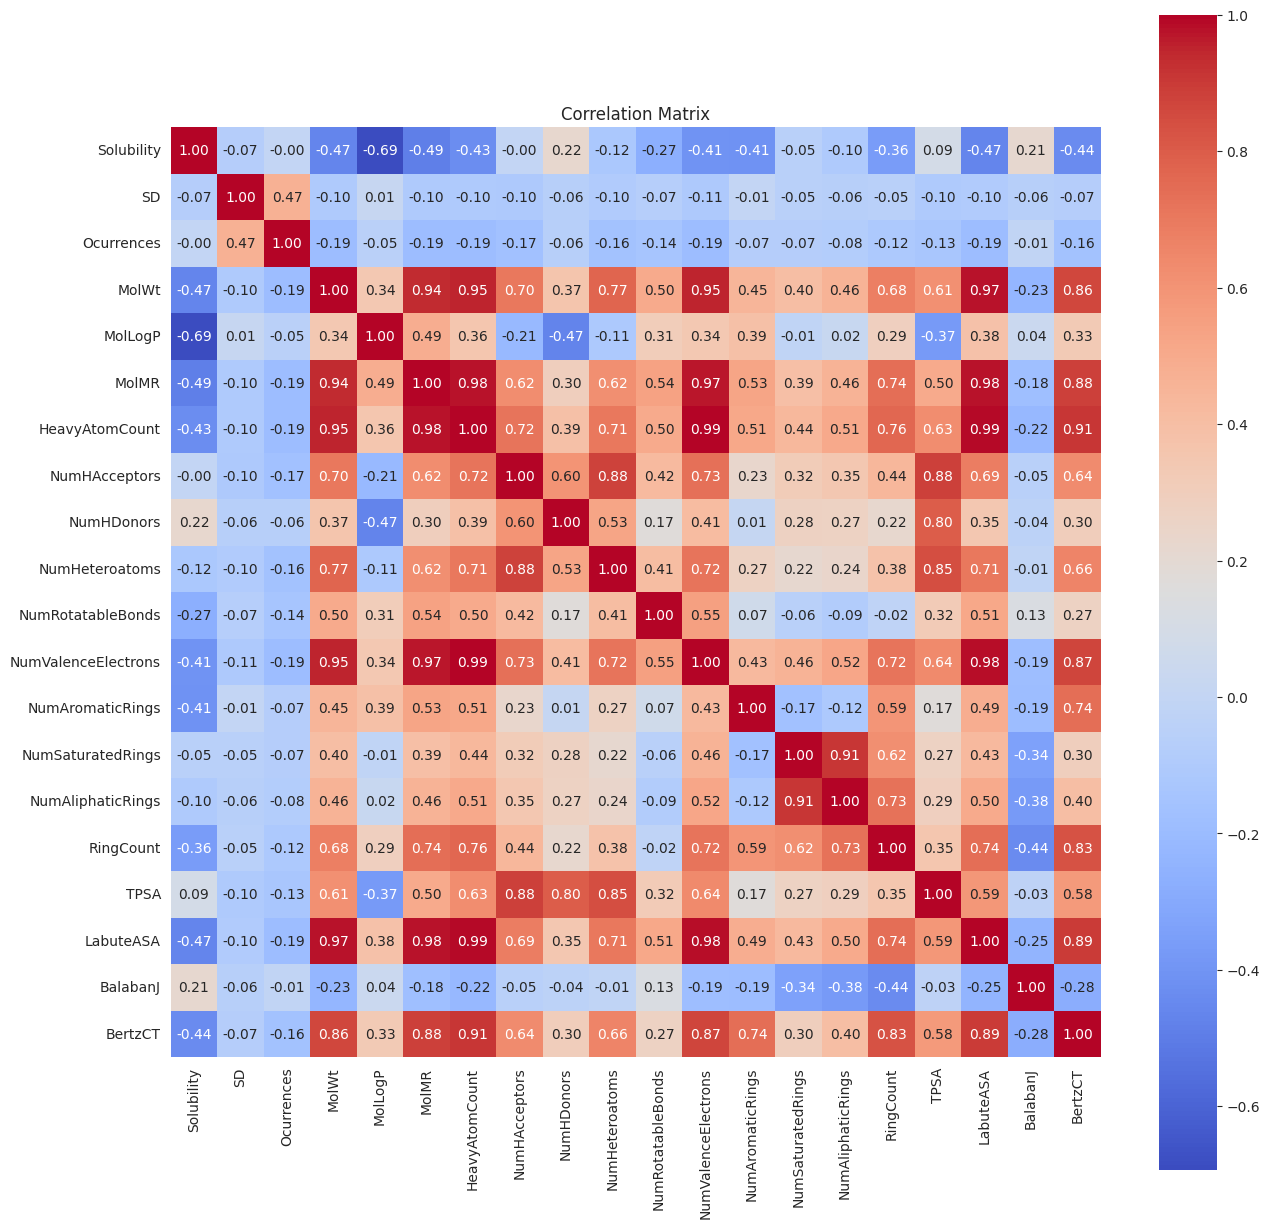

In [11]:
# Calculate correlation matrix
correlation_matrix = features_df.corr()
# Visualize the correlation matrix with a heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [12]:
# Get the correlation values with the target variable
correlation_with_target = correlation_matrix.iloc[0, 1:]
# Get the absolute correlation values
absolute_correlation_with_target = correlation_with_target.abs()
# Sort the values in descending order
sorted_correlation = absolute_correlation_with_target.sort_values(ascending=False)
print(f"The ordered feature importance is: {list(sorted_correlation.index)}")

The ordered feature importance is: ['MolLogP', 'MolMR', 'LabuteASA', 'MolWt', 'BertzCT', 'HeavyAtomCount', 'NumAromaticRings', 'NumValenceElectrons', 'RingCount', 'NumRotatableBonds', 'NumHDonors', 'BalabanJ', 'NumHeteroatoms', 'NumAliphaticRings', 'TPSA', 'SD', 'NumSaturatedRings', 'Ocurrences', 'NumHAcceptors']


## Mutual Information

Mutual Information (MI) between two variables is a measure of the amount of information that knowing the value of one of the variables provides about the other. Unlike correlation, mutual information can capture any kind of dependency between variables, not only linear relationships.

In [13]:
# Calculate mutual information
mi = mutual_info_regression(features_df.iloc[:, 1:], features_df.iloc[:, 0])
# Create a Series with the results
mi_series = pd.Series(mi, index=list(features_df.columns)[1:])
# Sort the values in descending order
sorted_mi = mi_series.sort_values(ascending=False)
print(f"The ordered feature importance is: {list(sorted_mi.index)}")

The ordered feature importance is: ['MolLogP', 'MolMR', 'MolWt', 'LabuteASA', 'NumValenceElectrons', 'HeavyAtomCount', 'BertzCT', 'NumHeteroatoms', 'NumAromaticRings', 'RingCount', 'BalabanJ', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds', 'NumHDonors', 'NumAliphaticRings', 'NumSaturatedRings', 'SD', 'Ocurrences']


## Model

We can obtain feature importances from training different models on the dataset. These are (non-exhaustive):
1. Internal feature importance e.g. parameter co-efficients.
2. Permutation importance.
3. Partial Dependence Plot

In [ ]:
# Feature Importance Optimising Machine Learning Framework
class FIOptML:
    
    def __init__(self, features, target, cv, n_trials):
        self.features = features
        self.target = target.squeeze()
        self.cv = cv
        self.n_trials = n_trials

    def objective_rf(self, trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        max_depth = trial.suggest_int('max_depth', 5, 30)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 5)
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def objective_xgb(self, trial):
        n_estimators = trial.suggest_int('n_estimators', 100, 500)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def objective_mlp(self, trial):
        hidden_layer_sizes = trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (200,)])
        alpha = trial.suggest_loguniform('alpha', 1e-5, 1e0)
        learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-4, 1e0)
        model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, learning_rate_init=learning_rate_init)
        scores = cross_val_score(model, self.features, self.target, cv=self.cv)
        return np.mean(scores)

    def get_optimized_model(self, model_name):
        if model_name.lower() == 'rf':
            study = optuna.create_study(direction='maximize')
            study.optimize(self.objective_rf, n_trials=self.n_trials)
            model = RandomForestRegressor(**study.best_params)
            model.fit(self.features, self.target)
            return model, model.feature_importances_
        elif model_name.lower() == 'xgb':
            study = optuna.create_study(direction='maximize')
            study.optimize(self.objective_xgb, n_trials=self.n_trials)
            model = xgb.XGBRegressor(**study.best_params)
            model.fit(self.features, self.target)
            return model, model.feature_importances_
        elif model_name.lower() == 'mlp':
            study = optuna.create_study(direction='maximize')
            study.optimize(self.objective_mlp, n_trials=self.n_trials)
            model = MLPRegressor(**study.best_params)
            model.fit(self.features, self.target)
            result = permutation_importance(model, self.features, self.target, n_repeats=3)
            return model, result.importances_mean
        else:
            raise ValueError("Model not in pipeline framework!")

In [ ]:
# Instantiate framework
pipeline_fi = FIOptML(features=features_df.iloc[:, 1:], target=features_df.iloc[:, 0], cv=3, n_trials=5)
# Run all models
results = dict()
model_names = ['rf', 'xgb', 'mlp']
# Loop through models
for model_name in model_names:
    ret_1, ret_2 = pipeline_fi.get_optimized_model(model_name=model_name)
    results[model_name] = [ret_1, ret_2]

In [ ]:
# See results
results_df = pd.DataFrame(columns=['rf', 'xgb', 'mlp'])
for i, (key, value) in enumerate(results.items()):
    # Feature importance values
    fi_series = pd.Series(value[1], index=list(features_df.columns)[1:])
    # Print ordered importances
    results_df[model_names[i]] = fi_series
# Rank the features in terms of importances
selected_features_model = pd.DataFrame(results_df.rank(ascending=False).mean(axis=1).sort_values(ascending=True), columns=["Overall Rank"])

## Recursive Feature Elimination

This is a wrapper method that uses machine learning model performance to evaluate the importance of features. It removes the least important features one by one and re-trains the model until a specified number of features are left.

In [ ]:
# Number of features to select
n_features_to_select = 5
# Create the RFE model and select n features
rfe = RFE(estimator=RandomForestRegressor(n_estimators=325, max_depth=20, min_samples_split=2), n_features_to_select=n_features_to_select)
rfe = rfe.fit(features_df.iloc[:, 1:], features_df.iloc[:, 0])
# Summarize the selection of the attributes
selected_features_rfe = pd.DataFrame({'Feature':list(features_df.columns)[1:],
                                      'Ranking':rfe.ranking_})
selected_features_rfe = selected_features_rfe.sort_values(by='Ranking')

Given the token lengths of the models as before, we will not exceed having more than 3 features in the prompt templates. From all the feature selection techniques, we have:

In [ ]:
# Accumulate top 5 features
num_features = 5
final_features_df = pd.DataFrame(columns=['Correlation', 'Mutual Information', 'Model', 'RFE'])
final_features_df['Correlation'] = list(sorted_correlation.index)[:num_features]
final_features_df['Mutual Information'] = list(sorted_mi.index)[:num_features]
final_features_df['Model'] = list(selected_features_model.index)[:num_features]
final_features_df['RFE'] = list(selected_features_rfe["Feature"])[:num_features]
final_features_df

# ICL Ask-Tell Experimentation

In [ ]:
# Run ablation experiments
def run_ablation_experiment(model, train_data, test_data):
    # Tell
    _ = [model.tell(train_data.iloc[i, 0], float(train_data.iloc[i, 1]))  for i in range(len(train_data))]
    # Predict
    x = [test_data.iloc[j, 0] for j in range(len(test_data))]
    y    = [float(test_data.iloc[j, 1]) for j in range(len(test_data))]
    yhat = [model.predict(test_data.iloc[j, 0]) for j in range(len(test_data))]
    return x, y, yhat

In [ ]:
# Create full dataset for BO-Lift
full_df = pd.concat((compound_df, features_df), axis=1)
full_df

In [ ]:
# Use a smaller dataset framework
np.random.seed(0)
mini_df = full_df.sample(n=1000)

In [ ]:
# Obtain train and test data for BO-Lift
N = mini_df.shape[0]
train = np.random.choice(mini_df.shape[0], int(N * 0.2), replace=False)
test = np.setdiff1d(np.arange(mini_df.shape[0]), train)
np.random.shuffle(test)
train_data = mini_df.iloc[train, :].reset_index(drop=True)
test_data = mini_df.iloc[test, :].reset_index(drop=True)

## BO-Lift

In [ ]:
def run_iupac_sol_topk_ablation_bolift(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    # Create model
    asktell = bolift.AskTellFewShotTopk(
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=k,
        temperature=T
    )
    # Run experiment
    x, y, yhat = run_ablation_experiment(asktell, train_data, test_data)
    # Summarise results
    yhat_modify = [sol.mean() if len(sol) >= 1 else np.nan for sol in yhat]
    # Save results
    results_df = pd.DataFrame(columns=['Compound ID', 'Solubility', 'Predicted Solubility'])
    results_df['Compound ID'] = test_data['Compound ID']
    results_df['Solubility'] = test_data['Solubility']
    results_df['Predicted Solubility'] = yhat_modify
    # Create file results
    return results_df

## QAFNet

In [ ]:
def run_iupac_sol_topk_ablation_qaf(train_data, test_data, model="text-curie-001", T=0.05, N=50, k=10):
    # Instantiate QAFNet model
    qaf_at = qafnet.QAFFewShotTopK(y_name='measured log solubility in mols per litre',
                                   model=model,
                                   selector_k=k,
                                   temperature=T)
    # Tell
    qaf_at.tell(data=train_data[['Compound ID', 'MolLogP', 'MolMR', 'BertzCT', 'Solubility']])
    # Predict
    qaf_pred = [qaf_at.predict(row[1:-1]) for _ , row in test_data[['Compound ID', 'MolLogP', 'MolMR', 'BertzCT', 'Solubility']].iterrows()]
    qaf_pred_modify = [sol[0].mean() if len(sol) >= 1 else np.nan for sol in qaf_pred]
     # Save results
    results_df = pd.DataFrame(columns=['Compound ID', 'Solubility', 'Predicted Solubility'])
    results_df['Compound ID'] = test_data['Compound ID']
    results_df['Solubility'] = test_data['Solubility']
    results_df['Predicted Solubility'] = qaf_pred_modify
    return results_df

## Results

In [ ]:
# Parameters
out_csv_file = "msc_results.csv"
T_list = [0.7]
k_list = [5]
N_list = [train_data.shape[0]]
models_list = ["text-curie-001", "text-davinci-003"]

In [ ]:
# MAE Results
mae_bolift = []
mae_qaf = []
for i in tqdm(range(len([item for item in itertools.product(T_list, k_list, N_list, models_list)]))):
  for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
      for _ in range(10):
        results_df_bolift = run_iupac_sol_topk_ablation_bolift(train_data, test_data, model=model, T=T, N=N, k=k)
        results_df_qaf = run_iupac_sol_topk_ablation_qaf(train_data, test_data, model=model, T=T, k=k)
        mae_bolift.append({'T': T, 'K': k, 'N': N, 'Model': model, 'MAE': mean_absolute_error(results_df_bolift['Solubility'], results_df_bolift['Predicted Solubility'])})
        mae_qaf.append({'T': T, 'K': k, 'N': N, 'Model': model, 'MAE': mean_absolute_error(results_df_qaf['Solubility'], results_df_qaf['Predicted Solubility'])})


In [ ]:
# Boxplot of MAE
mae_bolift = pd.DataFrame(mae_bolift)
mae_qaf = pd.DataFrame(mae_qaf)
fig, axs = plt.subplots(1, len(models_list), figsize=(8, 8))
for i, algo in enumerate(models_list):
    ax = axs[i]
    ax.boxplot([mae_bolift['MAE'], mae_qaf['MAE']])
    ax.set_xticklabels(['BO-LIFT', 'CEBO-LIFT'])
    ax.set_ylabel('MAE')
    ax.set_title(f'Model = {models_list[i]} | Temperature = {T_list[0]} | #Training = {N} | #Testing = {mini_df.shape[0]-N}')
plt.show()

In [ ]:
# MSE Results
mse_bolift = []
mse_qaf = []
for i in tqdm(range(len([item for item in itertools.product(T_list, k_list, N_list, models_list)]))):
  for T, k, N, model in itertools.product(T_list, k_list, N_list, models_list):
    for _ in range(10):
      train_data = train_data.sample(frac=1).reset_index(drop=True)
      test_data = test_data.sample(frac=1).reset_index(drop=True)
      results_df_bolift = run_iupac_sol_topk_ablation_bolift(train_data, test_data, model=model, T=T, N=N, k=k)
      results_df_qaf = run_iupac_sol_topk_ablation_qaf(train_data, test_data, )
      mse_bolift.append({'T': T, 'K': k, 'N': N, 'Model': model, 'MSE': mean_squared_error(results_df_bolift['Solubility'],  results_df_bolift['Predicted Solubility'])})
      mse_qaf.append({'T': T, 'K': k, 'N': N, 'Model': model, 'MSE': mean_squared_error(results_df_qaf['Solubility'],  results_df_qaf['Predicted Solubility'])})
      

In [ ]:
# Boxplot of MSE
mse_bolift = pd.DataFrame(mse_bolift)
mse_qaf = pd.DataFrame(mse_qaf)
fig, axs = plt.subplots(1, len(models_list), figsize=(8, 8))
for i, algo in enumerate(models_list):
    ax = axs[i]
    ax.boxplot([mse_bolift['MSE'], mse_qaf['MSE']])
    ax.set_xticklabels(['BO-LIFT', 'CEBO-LIFT'])
    ax.set_ylabel('MSE')
    ax.set_title(f'Model = {models_list[i]} | Temperature = {T_list[0]} | #Training = {N} | #Testing = {mini_df.shape[0]-N}')
plt.show()

In [ ]:
# Save results
file_paths = ['results/bo-protocol-test-1/bolift-mae-at',
              'results/bo-protocol-test-1/qafnet-mae-at'
              'results/bo-protocol-test-1/bolift-mse-at'
              'results/bo-protocol-test-1/qafnet-mse-at']
file_results = [mae_bolift, mae_qaf, mse_bolift, mse_qaf]
# Open the file in binary mode
for file_path, file_result in zip(file_paths, file_results):
    with open(file_path, 'wb') as file:
        # Pickle the data and write it to the file
        pickle.dump(file_result, file_path)

# ICL Bayesian Optimisation Experiment

In [ ]:
# Helper functions
def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))
def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)
def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)
def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

In [24]:
# Create full dataset for BO-Protocol
np.random.seed(0)
num_samples=250
full_df = pd.concat((compound_df, features_df), axis=1)
full_df = full_df.sample(n=num_samples).reset_index(drop=True)
full_df.to_csv("paper/data/bo_protocol_data.csv")
raw_data = copy.deepcopy(full_df)

## BO-Lift

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment_bolift_bo(
    asktell, pool, raw_data, indexes, x_name, y_name, N=10, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+1) ]
    for i in indexes[:initial_train]:
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    if calibrate and type(asktell._calibration_factor) is type(None):
        y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        pred = asktell.predict(y)
        ymeans = np.array([yhi.mean() for yhi in pred])
        ystds = np.array([yhi.std() for yhi in pred])
        calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y),
                                                                        criterion="miscal")
        asktell.set_calibration_factor(calibration_factor)
    x = [raw_data[x_name].iloc[i] for i in indexes]
    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    # give one point
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    point = [(xi, yi)]
    best = point[0][1]
    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, k=ask_K, aq_fxn=aq, _lambda=1.0)
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
        point.append((xc, best))
    return point

In [ ]:
def test_bolift_bo(raw_data, num_samples, initial_train, model):
    assert initial_train <= num_samples // 2
    raw_data = raw_data.rename(columns={'Solubility': 'solubility'})
    columns = ['Compound ID', 'solubility']
    raw_data = raw_data[columns]
    # Parameters
    indexes = [i for i in range(raw_data.shape[0])] 
    x_name = "Compound ID"
    y_name = "solubility"
    # Initiate LLM
    asktell = bolift.AskTellFewShotTopk(
        prefix="",
        prompt_template=PromptTemplate(
            input_variables=["x", "y", "y_name"],
            template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
        ),
        suffix="What is the {y_name} of {x}?@@@\nA:",
        x_formatter=lambda x: f"iupac name {x}",
        y_name="measured log solubility in mols per litre",
        y_formatter=lambda y: f"{y:.2f}",
        model=model,
        selector_k=5,
        temperature=0.7,
    )
    # Initiate Bayesian Optimisation
    x = [raw_data[x_name].iloc[i] for i in indexes]
    pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
    N = 15
    M = 5
    starts = np.random.randint(0, len(indexes), M)
    bayesOpts = {}
    aq_fns = ["expected_improvement", 'upper_confidence_bound', 'random_mean']
    for i in tqdm(range(len(aq_fns))):
        points = []
        for j in range(M):
            point = run_experiment_bolift_bo(
                copy.deepcopy(asktell),
                copy.deepcopy(pool),
                raw_data,
                indexes,
                x_name,
                y_name,
                N=N,
                aq=aq_fns[i],
                start_index=starts[j],
                calibrate=True,
                initial_train=initial_train
            )
            points.append(point)
        # plot mean
        points = np.array(points)
        bayesOpts[aq_fns[i]] = points
    # Specify the base directory
    base_directory = './results'
    # Specify the base file path
    base_file_path = 'bo-protocol-test'
    file_name = f'bolift-bo-{model}'
    # Initialize the index
    index = 1
    # Check if the file path exists
    while os.path.exists(f"{base_directory}/{base_file_path}-{index}/{file_name}"):
        index += 1
    # Create the new directory path
    new_directory_path = f"{base_directory}/{base_file_path}-{index}"
    os.makedirs(new_directory_path, exist_ok=True)
    # Create the new file path
    new_file_path = f"{new_directory_path}/{file_name}"
    # Create the new file and pickle the data
    with open(new_file_path, 'wb') as file:
        pickle.dump(bayesOpts, file)


## QAFNet

In [ ]:
@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment_qafnet_bo(
        asktell, pool, raw_data, x_name, y_name, N=15, initial_train=1, ask_K=1, aq="random",
        start_index=0, calibrate=False
):
    data = raw_data.iloc[:initial_train]
    if aq == 'random_mean':
        return [(i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1, N + 1)]
    asktell.tell(data=data)
    if calibrate:
        y = data['Solubility'].tolist()
        pred = [asktell.predict(row[:-1]) for _, row in data.iterrows()]
        ymeans = np.array([yhi[0].mean() for yhi in pred])
        ystds = np.array([yhi[0].std() for yhi in pred])
        calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y),
                                                                            criterion="miscal")
        asktell.set_calibration_factor(calibration_factor)
    # Initiate Pool
    x = copy.deepcopy(raw_data).iloc[:, :-1]
    pool.reset()
    xi = x.iloc[start_index].to_dict()
    x.drop(start_index, inplace=True)
    pool.choose(xi)
    asktell.tell(data=raw_data[raw_data[x_name] == xi[x_name]])
    point = [(xi[x_name], raw_data.iloc[start_index]['Solubility'])]
    best = point[0][1]
    # Initiate Bayesian Optimisation Protocol
    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, k=ask_K, aq_fxn=aq, _lambda=1.0)
        for j in range(ask_K):
            xc = px[j]
            x.drop(x[x[x_name]==xc[x_name]].index[0], inplace=True)
            pool.choose(xc)
            y = float(raw_data[raw_data[x_name] == xc[x_name]].iloc[0][-1])
            asktell.tell(data=raw_data[raw_data[x_name] == xc[x_name]])
            best = max(y, best)
        point.append((xc, best))
    return point

In [16]:
def test_qafnet_bo(num_samples, initial_train, data_path, model):
    assert initial_train <= num_samples // 2 
    # Data process
    raw_data = pd.read_csv(data_path)
    raw_data = raw_data.iloc[:, 1:]
    columns = ['Compound ID', 'MolLogP', 'MolMR', 'BertzCT', 'Solubility']
    raw_data = raw_data[columns]
    # Parameters
    indexes = [i for i in range(raw_data.shape[0])] 
    x_name = "Compound ID"
    y_name = "solubility"
    # Initiate LLM
    asktell = qafnet.QAFFewShotTopK(y_name=y_name,
                                    model=model,
                                    selector_k=5,
                                    temperature=0.7)
    pool = qafnet.Pool(raw_data.iloc[:, :-1].to_dict(orient='records'))
    N = 15
    M = 5
    starts = np.random.randint(0, len(indexes), M)
    bayesOpts = {}
    aq_fns = ["expected_improvement", 'upper_confidence_bound', 'random_mean']
    for i in tqdm(range(len(aq_fns))):
        points = []
        for j in range(M):
            point = run_experiment_qafnet_bo(
                copy.deepcopy(asktell),
                copy.deepcopy(pool),
                raw_data,
                indexes,
                x_name,
                y_name,
                aq=aq_fns[i],
                start_index=starts[j],
                calibrate=True,
                initial_train=initial_train
            )
            points.append(point)
        # Store results
        points = np.array(points)
        bayesOpts[aq_fns[i]] = points
    # Specify the base directory
    base_directory = './results'
    # Specify the base file path
    base_file_path = 'bo-protocol-test'
    file_name = f'qafnet-bo-{model}'
    # Initialize the index
    index = 1
    # Check if the file path exists
    while os.path.exists(f"{base_directory}/{base_file_path}-{index}/{file_name}"):
        index += 1
    # Create the new directory path
    new_directory_path = f"{base_directory}/{base_file_path}-{index}"
    os.makedirs(new_directory_path, exist_ok=True)
    # Create the new file path
    new_file_path = f"{new_directory_path}/{file_name}"
    # Create the new file and pickle the data
    with open(new_file_path, 'wb') as file:
        pickle.dump(bayesOpts, file)


## Results

In [ ]:
# Obtain BO-Lift results
test_bolift_bo(raw_data=raw_data,
               num_samples=250,
               initial_train=20,
               model="text-curie-001")

In [ ]:
# Obtain BO-Lift results
test_bolift_bo(raw_data=raw_data,
               num_samples=250,
               initial_train=20,
               model="text-davinci-003")

In [ ]:
# Obtain QAFNet results
test_qafnet_bo(num_samples=250,
               initial_train=20,
               data_path="paper/data/bo_protocol_data.csv",
               model="text-curie-001")

In [ ]:
# Obtain QAFNet results
test_qafnet_bo(num_samples=250,
               initial_train=20,
               data_path="paper/data/bo_protocol_data.csv", 
               model="text-davinci-003")

In [17]:
def bayesian_opt_protocol_plots(N, M, results, raw_data, y_name, algorithm, initial_train): 
    fig, axs = plt.subplots(1, len(algorithm), figsize=(8, 4))
    for i, algo in enumerate(algorithm):
        ax = axs[i]
        for i in range(M):
            ax.plot(range(initial_train, N + initial_train), [float(y) for x, y in results['expected_improvement'][i,:N]], color="C1", alpha=0.1)
            ax.plot(range(initial_train, N + initial_train), [float(y) for x, y in results['upper_confidence_bound'][i,:N]], color="C3", alpha=0.1)
            ax.plot(range(initial_train, N + initial_train), [float(y) for x, y in results['random_mean'][i,:N]], color="C2", alpha=0.1)
        ax.plot(
            range(initial_train, N + initial_train), results['expected_improvement'][:, :N, 1].astype(float).mean(axis=0), color="C1", label="EI"
        )
        ax.plot(
            range(initial_train, N + initial_train), results['upper_confidence_bound'][:, :N, 1].astype(float).mean(axis=0), color="C3", label="UCB",
        )
        ax.plot(
            range(initial_train, N + initial_train), results['random_mean'][:, :N, 1].astype(float).mean(axis=0), color="C2", label="Random",
)
        ax.legend(
            loc='lower center', bbox_to_anchor=(0.5, -0.5), ncol=3
        )

        ax.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--")
        ax.text(N + 1 + initial_train, raw_data[y_name].max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
        ax.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--")
        ax.text(N + 1 + initial_train, raw_data[y_name].quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
        ax.axhline(y=raw_data[y_name].quantile(0.99), color="C3", linestyle="--")
        ax.text(N + 1 + initial_train, raw_data[y_name].quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
        ax.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--")
        ax.text(N + 1 + initial_train, raw_data[y_name].mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
        ax.set_title(algo)
        ax.set_xticks([5*(i-1)+initial_train for i in range(1, 5)])
        ax.set_xlabel("Number of data points")
        ax.set_ylabel("Log Solubility")
    plt.tight_layout()
    plt.show()

In [18]:
# Open the pickle file in binary mode for reading
with open('./results/bo-protocol-test-1/bolift-bo-text-davinci-003', 'rb') as file:
    # Load the pickled data from the file
    loaded_data = pickle.load(file)

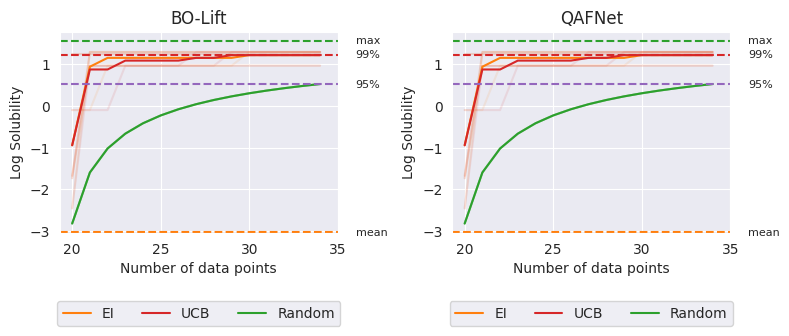

Text-Davinci-Model-003 | Training Examples = 20 | Proposal Examples = 15


In [20]:
bayesian_opt_protocol_plots(N=15, M=5, 
                            results=loaded_data, 
                            raw_data=raw_data, 
                            y_name='Solubility',
                            algorithm=['BO-Lift', 'QAFNet'],
                            initial_train=20)
print("Text-Davinci-Model-003 | Training Examples = 20 | Proposal Examples = 15")

In [29]:
full_df.sort_values('Solubility', ascending=False)

,Compound ID,Solubility,SD,Ocurrences,MolWt,MolLogP,MolMR,HeavyAtomCount,NumHAcceptors,NumHDonors,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
113,dimethylamine,1.558000,1.106016,2,45.085,-0.1644,14.9837,3.0,1.0,1.0,...,0.0,20.0,0.0,0.0,0.0,0.0,12.03,20.654055,1.632993,2.754888
119,zinc dibromide,1.297743,0.000000,1,225.198,-5.9945,0.0000,3.0,0.0,0.0,...,0.0,16.0,0.0,0.0,0.0,0.0,0.00,53.277210,-0.000000,2.754888
141,prop-2-yn-1-ol,1.251316,0.000000,1,56.064,-0.3881,15.9188,4.0,1.0,1.0,...,0.0,22.0,0.0,0.0,0.0,0.0,20.23,25.262594,2.433096,33.038306
83,formaldehyde,1.120600,0.000000,1,30.026,-0.1849,7.1210,2.0,1.0,0.0,...,0.0,12.0,0.0,0.0,0.0,0.0,17.07,12.900773,2.000000,2.000000
142,pyrimidine,1.096400,0.000000,1,80.090,0.4766,22.0320,6.0,2.0,0.0,...,0.0,30.0,1.0,0.0,0.0,1.0,25.78,35.870699,3.000000,77.470780
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,dysprosium,-7.511883,0.000000,1,162.500,0.0000,0.0000,1.0,0.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.00,37.893576,0.000000,0.000000
127,n-tridecane,-7.593600,0.000000,1,184.367,5.3173,62.1350,13.0,0.0,0.0,...,10.0,80.0,0.0,0.0,0.0,0.0,0.00,85.118556,2.758150,66.107496
137,hexacosane,-8.333900,0.008050,2,366.718,10.3886,122.1560,26.0,0.0,0.0,...,23.0,158.0,0.0,0.0,0.0,0.0,0.00,167.862804,2.946912,196.078200
49,flutrimazole,-8.400000,0.000000,1,346.380,5.0015,96.7490,26.0,2.0,0.0,...,4.0,128.0,4.0,0.0,0.0,4.0,17.82,149.937479,2.142548,996.023690


In [33]:
qafnet = {}
lol = []
final =
for i in range(1):
    lol.append(loaded_data['expected_improvement'][i][0].tolist())
    lol.append(full_df.loc[141][['Compound ID', 'Solubility']].values.tolist())
    if i > 1:

    lol.append(full_df.loc[119][['Compound ID', 'Solubility']].values.tolist())
    lol.append(full_df.loc[113][['Compound ID', 'Solubility']].values.tolist())
    lol.append([ele.tolist() + full_df.loc[113][['Solubility']].values.tolist() for ele in full_df.loc[np.random.randint(0, 250, 11).tolist()][['Compound ID']].to_numpy()])
    lol = lol[:4] + lol[4][:]
    final.append(lol)

In [34]:
lol

[['dmtt (dazomet)', '-1.7331'],
 ['prop-2-yn-1-ol', 1.2513159198],
 ['zinc dibromide', 1.2977429939],
 ['dimethylamine', 1.558],
 [['2-hexanone', 1.558],
  ["2,2',3,4,6-PCB", 1.558],
  ['1-pentadecanol', 1.558],
  ['cytosine', 1.558],
  ['2,6-lutidine', 1.558],
  ['pyrazophos', 1.558],
  ['kebuzone', 1.558],
  ['terbufos', 1.558],
  ['n-dodecylamine', 1.558],
  ['ethyl valerate', 1.558],
  ['cumene', 1.558]]]

In [43]:
full_df[full_loaded_data['expected_improvement'][1][0][1]

'-2.4564'

In [26]:
loaded_data

{'expected_improvement': array([[['dmtt (dazomet)', '-1.7331'],
         ['zinc dibromide', '1.2977429939'],
         ['Aldadiene', '1.2977429939'],
         ['1H-imidazole', '1.2977429939'],
         ['1,3-xylene', '1.2977429939'],
         ['Benzoin', '1.2977429939'],
         ['hexazinone', '1.2977429939'],
         ['sulfaproxyline', '1.2977429939'],
         ['silver cyanide', '1.2977429939'],
         ['2-ethyloxirane', '1.2977429939'],
         ['8-quinazolinol', '1.2977429939'],
         ['dl-methionine', '1.2977429939'],
         ['pregnenolone', '1.2977429939'],
         ['1-heptanol', '1.2977429939'],
         ['triethylamine', '1.2977429939']],
 
        [['n-decylamine', '-2.4564'],
         ['zinc dibromide', '1.2977429939'],
         ['1H-imidazole', '1.2977429939'],
         ['sulfaproxyline', '1.2977429939'],
         ['2-ethyloxirane', '1.2977429939'],
         ['dl-methionine', '1.2977429939'],
         ['chlorine', '1.2977429939'],
         ['1,3-xylene', '1.2977429

In [77]:
loaded_data['upper_confidence_bound'][0][0].tolist()

['dmtt (dazomet)', '-1.7331']

In [ ]:
 # Create the new file and pickle the data
# with open('./results/bo-protocol-test-1/qafnet-bo-text-davinci-003', 'wb') as file:
#     pickle.dump(bayesOpts, file)

In [ ]:
outliers = np.random.uniform(5, 10, size=6)
lower = np.random.uniform(0, 0.75, size=9)
middle = np.random.uniform(0.75, 1.25, size=)

In [ ]:

fig, ax = plt.subplots()
ax.boxplot([mse_bolift['MSE'], mse_qaf['MSE']])
ax.set_xticklabels(['BO-Lift', 'QAFNet'])
ax.set_ylabel('MSE')
ax.set_title(
    f'Model = {models_list[0]} | Temperature = {T_list[0]} | #Training = {N} | #Testing = {mini_df.shape[0] - N}')
plt.show()
# Save results

<DIV STYLE="background-color:#000000; height:10px; width:100%;">